# ボルツマン機械学習にD-Waveマシンを用いる(実践編part2)

## 概要

本記事は、[こちらの論文](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.7.041052#fulltext)の再現実験を行ったものです。具体的には、D-Waveマシンを用いて、ランダムなイジング模型(SK模型)を学習出来るか検証します。

この論文に関する詳しい解説は、[T-Wave](https://qard.is.tohoku.ac.jp/T-Wave/)をご覧ください。

## 文献情報



*   タイトル：Quantum-Assisted Learning of Hardware-Embedded Probabilistic Graphical Models
*   著者：Marcello Benedetti, John Realpe-Gómez, Rupak Biswas and Alejandro Perdomo-Ortiz
*   書誌情報：Phys. Rev. X 7, 041052 (2017)
*   DOI : 10.1103/PhysRevX.7.041052





## 問題

### SK模型の学習

SK模型とは、すべてのスピン間に対して同じ確率分布に従った相互作用を与えるイジング模型です。本論文では、次のパラメータを用いてSK模型のトレーニングセットを作成しました。

| パラメータ  | &nbsp; 値  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; | 説明 |
| :---: | :---: | :---: |
|  $N$  |  15  | スピン数 | 
|  $h$  |  0  | 局所磁場 |
|  $\beta$ |  1  | 逆温度 |
|  $\mu$  |  0  | 平均 |
|  $\sigma$  | $2/\sqrt{𝑁}$ | 標準偏差 |

本実験は、


*   厳密勾配
*   シミュレーテッド・アニーリング(SA)
*   量子アニーリング(QA)

の３つの手法で学習を行います。QAに関しては、D-Waveマシンを用いて実験を行います。また、収束の速さを比較するための尺度として、次の平均対数尤度を用います。



$$
\begin{aligned}
\Lambda_{\mathrm{av}}(S) &=\frac{1}{L} \sum_{l=1}^{L} \log Q\left(\mathbf{s}^{(l)}\right) \\
&=-\beta \frac{1}{L} \sum_{l=1}^{L} E\left(\mathbf{s}^{(l)}\right)-\log Z(\beta)
\end{aligned}
$$

ここで、$Q\left(s^{(l)}\right)$は、カノニカル分布です。

$$
Q\left(s^{(l)}\right)=\frac{1}{Z} \exp (-\beta E(s^{(l)})), \quad Z=\sum_{s^{(l)}} \exp (-\beta E(s^{(l)}))
$$

また、本実験では局所磁場$h_i=0$とするため、イジング模型のエネルギー$E(s^{(l)})$は、

$$
E(s^{(l)})=-\sum_{i, j} J_{i j} s_{i}^{(l)} s_{j}^{(l)}
$$
となります。ここで、$s^{(l)}_{i}∈ \lbrace -1, +1 \rbrace$は、イジング変数です。

### 学習方法

本実験では、相互作用$J$を次の勾配法を用いて学習させていきます。

$$
J_{i j}(t+1)=J_{i j}(t)+\eta \frac{\partial S}{\partial J_{i j}}
$$

$$
\frac{1}{\beta} \frac{\partial S}{\partial J_{i j}}=\left\langle s_{i} s_{j}\right\rangle_{\rho _\mathcal{D}}-\left\langle s_{i} s_{j}\right\rangle_{\rho}
$$

ここで、$S$は量子相対エントロピーです。

$$
S\left(\rho_{{D}} \| \rho\right)=\operatorname{Tr} \rho_{{D}} \ln \rho_{{D}}-\operatorname{Tr} \rho_{{D}} \ln \rho
$$

また、パラメータの説明は次の通りです。

| 　パラメータ  | 説明 |
| :---: | :---: |
| $t$  |  学習回数  |
| $\eta$  |  学習率  |
| $\beta$  |  逆温度  |
| $\rho_D$  |  データセットの分布を表す、<br>対角線上の密度行列  |
| $\rho$  |  サンプルの分布を表す、<br>対角線上の密度行列  |

## 実験

## 全体像

実験の全体像を示します。

![全体像](figures/fig1.svg)

まず最初に、ガウス分布に従うスピン配位(データ)を準備します。次に、ギブス・ボルツマン分布に従うスピン配位(サンプル)を作成します。このサンプルが、データに近づくように勾配法を用いて相互作用$J$を更新していきます。

### ライブラリのインストール

ここで、必要なライブラリをインストールします。

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install dwave-ocean-sdk
!pip install openjij
!pip install tqdm

In [ ]:
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
import openjij as oj
from tqdm import tqdm

### ガウス分布から相互作用の作成

まず、ガウス分布から相互作用$J$（インスタンス）を１つ生成します。ここで、パラメータは上記した通り、

|  パラメータ  | &nbsp; 値  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; | 説明 |
| :---: | :---: | :---: |
|  $N$  |  15  | スピン数 | 
|  $h$  |  0  | 局所磁場 |
|  $\beta$ |  1  | 逆温度 |
|  $\mu$  |  0  | 平均 |
|  $\sigma$  | $2/\sqrt{𝑁}$ | 標準偏差 |


としています。

In [ ]:
def J_generator(N, mu, sigma):
    """確率分布から相互作用を作成"""
    J = {
        (i, j): np.random.normal(loc=mu, scale=sigma)
        for i in range(N)
        for j in range(i + 1, N)
    }
    return J

In [ ]:
ans_J = J_generator(N=15, mu=0, sigma=2 / np.sqrt(15))

### 相互作用からスピン配位の作成

次に、作成した相互作用$J$を用いて、SK模型のスピン配位を150個サンプリングします。

ここでは、サンプリングにMCMC(メトロポリス法)を利用します。手順は次の通りです。



> 1.   全サイトからある１サイトを乱数により選択し、 そのサイトのスピンの向きを反転させた状態を試行状態とする
> 2.   試行状態におけるエネルギーと元の状態のエネルギーの差$\Delta E$を求める。
> 3.   以下の判定により、試行状態を新たな状態とするか、もとの状態を維持するかを決める。
> *   $\Delta E < 0$の場合には、試行状態を新たな状態とする。
> *   一方、$\Delta E > 0$の場合には、 乱数$a$ を $0≤a≤1$ の範囲で生成する。 $a<\exp(-\beta \Delta E)$ の場合には、 試行状態を新たな状態とする。そうでない場合にはもとの状態を維持する。
>
> 4.   1~3を繰り返す。
>
> 引用元：http://www.cmpt.phys.tohoku.ac.jp/~izumida/Ising/IsingMCMP.html

In [ ]:
def cal_energy(N, J, spin):
    energy = np.sum(
        [-J[(i, j)] * spin[i] * spin[j] for i in range(N) for j in range(i + 1, N)]
    )
    return energy


def MCMC(N, J, iter, beta=1):
    # スピン配位をランダムに生成
    minS = np.random.choice([-1, 1], size=N)
    # 初期状態のエネルギー
    minE = cal_energy(N=N, J=J, spin=minS)

    for n in range(iter):
        # 反転するスピンをランダムに決定
        i = np.random.randint(0, N)

        # １つのスピンを反転
        flipS = minS.copy()
        flipS[i] *= -1
        flipE = cal_energy(N=N, J=J, spin=flipS)

        # 反転前と後のエネルギーの差
        deltaE = flipE - minE
        if deltaE < 0:
            minE = flipE
            minS = flipS.copy()
        else:
            a = random.random()
            p = np.exp(-beta * deltaE)
            if a < p:
                minE = flipE
                minS = flipS.copy()
            else:
                pass

    return minS

準備が終わりました。

150個のスピン配位を作成しましょう。

In [ ]:
def MCMC_sampling(num_instances):
    sample_lists = []
    for i in range(num_instances):
        sample = MCMC(N=15, J=ans_J, iter=100)
        sample_lists.append(sample)
    return sample_lists

In [ ]:
data_lists = MCMC_sampling(num_instances=150)

これで、相互作用$J$からスピン配位を作成できました。

### 正解となる平均対数尤度の計算

ここでは、作成したスピン配位による平均対数尤度を計算します。平均対数尤度は次で表せました。

$$
\begin{aligned}
\Lambda_{\mathrm{av}}(S) &=\frac{1}{L} \sum_{l=1}^{L} \log Q\left(\mathbf{s}^{(l}\right) \\
&=-\beta \frac{1}{L} \sum_{l=1}^{L} E\left(\mathbf{s}^{(l)}\right)-\log Z(\beta)
\end{aligned}
$$

まず、平均対数尤度の第１項部分を求めます。

In [ ]:
def cal_first(beta, J, data_lists):
    energy_ave = np.average(
        [cal_energy(N=len(data_list), J=J, spin=data_list) for data_list in data_lists]
    )
    first = -beta * energy_ave
    return first

In [ ]:
data_first = cal_first(beta=1, J=ans_J, data_lists=data_lists)
print(data_first)

16.03394926364786


第１項が計算できました。続いて、平均対数尤度の第２項を求めます。

In [ ]:
def cal_second(beta, N, J):
    state_sum = np.sum(
        [
            np.exp(-beta * cal_energy(N=N, J=J, spin=z))
            for z in itertools.product([-1, 1], repeat=N)
        ]
    )
    second = np.log(state_sum)
    return second

In [ ]:
data_second = cal_second(beta=1, N=15, J=ans_J)
print(data_second)

20.954922044868276


２つを合計して平均対数尤度を求めましょう。

In [ ]:
# 教師データの平均対数尤度
data_LH = data_first - data_second
print(data_LH)

-4.920972781220417


これで、正解となる平均対数尤度を求めることが出来ました。

### QAによる学習

まず初めに、QAによる学習を行います。使用する勾配法をもう一度記載します。

$$
J_{i j}(t+1)=J_{i j}(t)+\eta \frac{\partial S}{\partial J_{i j}}
$$

$$
\frac{1}{\beta} \frac{\partial S}{\partial J_{i j}}=\left\langle s_{i} s_{j}\right\rangle_{\rho _\mathcal{D}}-\left\langle s_{i} s_{j}\right\rangle_{\rho}
$$

ここで、期待値$\left\langle{}\right\rangle_{\rho}$は

$$
\left\langle s_{i} s_{j}\right\rangle_{\rho} = \frac{1}{L} \sum_{l=1}^{L} s_{i}^{(l)} s_{j}^{(l)}
$$

のように、D-Waveマシンをサンプラーとして用いることで近似的に求められます。

In [ ]:
def minus_J(num_spin, J):
    """コスト関数の相互作用にマイナスがついているため、それに従って実装します"""
    m_J = {
        (i, j): J[(i, j)] * -1 for i in range(num_spin) for j in range(i + 1, num_spin)
    }
    return m_J


def sampling(method, h, J, Nsample, beta):
    if method == "QA":
        sampleset = sampler.sample_ising(
            h=h,
            J=J,
            num_reads=Nsample,
            beta=beta,
            answer_mode="raw",
            postprocess="sampling",
        )
    if method == "SA":
        sampleset = sampler.sample_ising(
            h=h, J=J, num_reads=Nsample, beta_min=beta, beta_max=beta
        )
    return sampleset


def train_model(method, Tall, Nsample, beta, eta, data_lists, sampler):
    num_data = len(data_lists)
    num_spin = len(data_lists[0])

    # パラメータの初期値を0とする
    train_J = {(i, j): 0 for i in range(num_spin) for j in range(i + 1, num_spin)}
    h = {i: 0 for i in range(num_spin)}

    # 教師データの経験平均
    data_ave = {}
    for i in range(num_spin):
        for j in range(i + 1, num_spin):
            data_ave[(i, j)] = np.average(
                [data_lists[k][i] * data_lists[k][j] for k in range(len(data_lists))]
            )

    LH_hists = {}
    for t in tqdm(np.arange(Tall)):
        # サンプリング
        m_J = minus_J(num_spin=num_spin, J=train_J)
        sampleset = sampling(method, h, m_J, Nsample, beta)
        sample_lists = sampleset.record.sample

        for i in range(num_spin):
            for j in range(i + 1, num_spin):
                sample_ave = np.average(
                    [
                        sample_lists[k][i] * sample_lists[k][j]
                        for k in range(len(sample_lists))
                    ]
                )
                train_J[(i, j)] += eta * beta * (data_ave[(i, j)] - sample_ave)

        # 一定の学習回数ごとにパラメータを保存
        if (t + 1) % 10 == 0 or (t + 1) == 1:
            m_J = minus_J(num_spin=num_spin, J=train_J)
            sampleset = sampling(method=method, h=h, J=m_J, Nsample=150, beta=beta)
            sample_lists = sampleset.record.sample
            first = cal_first(beta=beta, J=train_J, data_lists=sample_lists)
            second = cal_second(beta=beta, N=num_spin, J=train_J)
            LH_hists[t + 1] = first - second

    return train_J, LH_hists

これで、学習の準備が終わりました。パラメータの学習を行いましょう。

In [ ]:
from dwave.system import DWaveSampler, EmbeddingComposite, DWaveCliqueSampler

sampler_config = {"solver": "DW_2000Q_6", "token": "YOUR_TOKEN"}
sampler = EmbeddingComposite(DWaveSampler(**sampler_config))

In [ ]:
QA_J, LH_QAhists = train_model(
    method="QA",
    Tall=100,
    Nsample=1000,
    beta=1,
    eta=0.01,
    data_lists=data_lists,
    sampler=sampler,
)

100%|██████████| 100/100 [03:29<00:00,  2.10s/it]


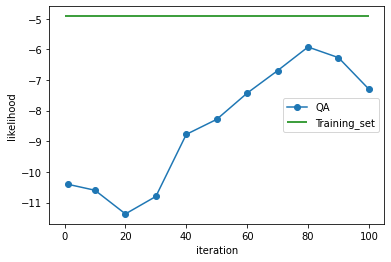

In [ ]:
LH_QAlist = LH_QAhists.items()
QAx, QAy = zip(*LH_QAlist)

plt.plot(QAx, QAy, label="QA", marker="o")
plt.hlines(data_LH, 0, 100, colors="green", label="Training_set")
plt.xlabel("iteration")
plt.ylabel("likelihood")
plt.legend(loc="center right")
plt.show()

これで、QAによる学習は終わりです。

### SAによる学習

次に、SAによる学習を行います。SAとQAの違いはソルバーを変更するだけなので、

早速、学習を開始しましょう。

In [ ]:
sampler = oj.SASampler()

In [ ]:
SA_J, LH_SAhists = train_model(
    method="SA",
    Tall=100,
    Nsample=1000,
    beta=1,
    eta=0.01,
    data_lists=data_lists,
    sampler=sampler,
)

100%|██████████| 100/100 [02:10<00:00,  1.31s/it]


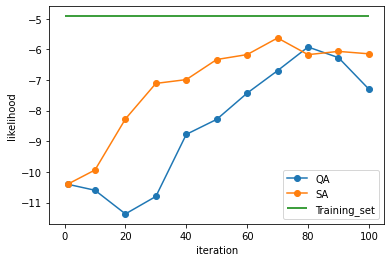

In [ ]:
LH_SAlist = LH_SAhists.items()
SAx, SAy = zip(*LH_SAlist)

plt.plot(QAx, QAy, label="QA", marker="o")
plt.plot(SAx, SAy, label="SA", marker="o")
plt.hlines(data_LH, 0, 100, colors="green", label="Training_set")
plt.xlabel("iteration")
plt.ylabel("likelihood")
plt.legend(loc="lower right")
plt.show()

SAによる学習は、これで終了です。

### 厳密勾配による学習

最後に、期待値の計算をサンプリングによる近似ではなく、厳密に計算することで学習を行います。

勾配法を、もう一度記載します。

$$
J_{i j}(t+1)=J_{i j}(t)+\eta \frac{\partial S}{\partial J_{i j}}
$$

$$
\frac{1}{\beta} \frac{\partial S}{\partial J_{i j}}=\left\langle s_{i} s_{j}\right\rangle_{\rho _\mathcal{D}}-\left\langle s_{i} s_{j}\right\rangle_{\rho}
$$

QA、SAの場合、期待値$\left\langle{}\right\rangle_{\rho}$は

$$
\left\langle s_{i} s_{j}\right\rangle_{\rho} = \frac{1}{L} \sum_{l=1}^{L} s_{i}^{(l)} s_{j}^{(l)}
$$

として近似的に求めました。ここでは、この部分を厳密に計算していきます。

具体的には、次の式で求められます。

$$
\left\langle s_{i} s_{j}\right\rangle_{\rho}=\sum_{s_{i}=\pm 1} \sum_{s_{j}=\pm 1} s_{i} ・ s_{j} ・ P\left(s_{i}, s_{j}\right)
$$

ここで、$P\left(s_{i}, s_{j}\right)$は同時確率で
$$
P\left(s_{i}, s_{j}\right) = \sum_{\mathbf{s} \backslash s_i, s_j} P(\mathbf{s})
$$
として求められます。$\mathbf{s} \backslash s_i, s_j$　は、$s_i, s_j$以外全ての$\mathbf{s}$を表しています。

例)　$N=3, i=1, j=2$の場合


$$
\left\langle s_{1} s_{2}\right\rangle_{\rho}=\sum_{s_{1}=\pm 1} \sum_{s_{2}=\pm 1} s_{1} ・ s_{2} ・ P\left(s_{1,} s_{2}\right)
$$

ここで、$P\left(s_{1}, s_{2}\right)$は
$$
P\left(s_{1}, s_{2}\right) = \sum_{\mathbf{s} \backslash s_1 s_2} P(\mathbf{s}) = P(s_1, s_2, -1) + P(s_1, s_2, +1)
$$

となります。$P(s_1, s_2, s_3)$は、カノニカル分布
$$
P(\mathbf{s})=\frac{1}{Z} \exp (-\beta E(\mathbf{s})), \quad Z=\sum_{\mathbf{s}} \exp (-\beta E(\mathbf{s}))
$$

から求められます。

In [ ]:
def cal_statesum(N, J, beta):
    """分配関数の計算"""
    statesum = np.sum(
        [
            np.exp(-beta * cal_energy(N=N, J=J, spin=spin_list))
            for spin_list in itertools.product([-1, 1], repeat=N)
        ]
    )
    return statesum

In [ ]:
def arg_lists(i, j, N):
    """同時確率の引数"""
    arg_lists = []
    for z in itertools.product([-1, 1], repeat=N - 2):
        arg_list = list(z)
        arg_list.insert(i, "zi")
        arg_list.insert(j, "zj")
        arg_lists.append(arg_list)
    return arg_lists

In [ ]:
def canonical(statesum, beta, N, J, arg_list):
    """カノニカル分布"""
    energy = cal_energy(N=N, J=J, spin=arg_list)
    canonical = np.exp(-beta * energy) / statesum
    return canonical

In [ ]:
def joint_prob(N, i, j, arg_lists, zi, zj, ca_dict):
    """同時確率"""
    joint_prob = 0
    for arg_list in arg_lists:
        arg_list[i], arg_list[j] = zi, zj
        joint_prob += ca_dict[tuple(arg_list)]
    return joint_prob

In [ ]:
def exact_grad(Tall, beta, N, eta):
    # パラメータの初期値を0とする
    train_J = {(i, j): 0 for i in range(N) for j in range(i + 1, N)}

    # 教師データの経験平均
    data_ave = {}
    for i in range(N):
        for j in range(i + 1, N):
            data_ave[(i, j)] = np.average(
                [data_lists[k][i] * data_lists[k][j] for k in range(len(data_lists))]
            )

    LH_hists = {}
    for t in tqdm(np.arange(Tall)):
        # 使用するカノニカル分布を先に計算
        statesum = cal_statesum(N=N, J=train_J, beta=1)
        ca_dict = {}
        for spin_list in itertools.product([-1, 1], repeat=N):
            ca_dict[spin_list] = canonical(
                statesum=statesum, beta=1, N=N, J=train_J, arg_list=spin_list
            )

        for i in range(N):
            for j in range(i + 1, N):
                exact_exval = 0
                for z in itertools.product([-1, 1], repeat=2):
                    zi, zj = z[0], z[1]
                    jp = joint_prob(
                        N=N,
                        i=i,
                        j=j,
                        arg_lists=arg_lists(i, j, N),
                        zi=zi,
                        zj=zj,
                        ca_dict=ca_dict,
                    )
                # 相互作用の更新
                train_J[(i, j)] += eta * beta * (data_ave[(i, j)] - exact_exval)

        # 一定の学習回数ごとにパラメータを保存
        if (t + 1) % 1 == 0 or (t + 1) == 1:
            first = cal_first(beta=beta, J=train_J, data_lists=data_lists)
            second = cal_second(beta=beta, N=N, J=train_J)
            LH_hists[t + 1] = first - second

    return train_J, LH_hists

これで、準備が終わりました。実行してみましょう。

QAやSAより計算回数が多いため、時間がかかります。

In [ ]:
exact_J, exact_hists = exact_grad(Tall=100, beta=1, N=15, eta=0.01)

100%|██████████| 100/100 [37:48<00:00, 22.69s/it]


それでは、全ての結果を同じグラフにプロットしてみましょう。

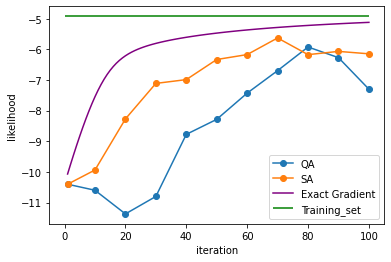

In [ ]:
exact_list = exact_hists.items()
EXx, EXy = zip(*exact_list)

plt.hlines(data_LH, 0, 100, colors="green", label="Training_set")
plt.plot(QAx, QAy, label="QA", marker="o")
plt.plot(SAx, SAy, label="SA", marker="o")
plt.plot(EXx, EXy, label="Exact Gradient", color="purple")
plt.xlabel("iteration")
plt.ylabel("likelihood")
plt.legend(loc="lower right")
plt.show()

これで、実験は終了です。

最後に、５インスタンスで実験を行った結果を示します。プロットが平均値、エラーバーが標準偏差です。

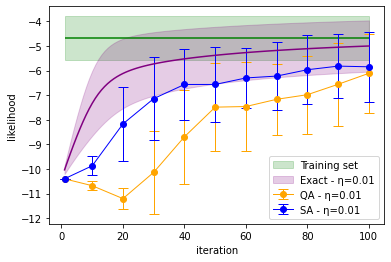

これより、QAに比べてSAの方がより速く収束していくことが分かりました。

## あとがき

[論文](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.7.041052#fulltext)では、QAとSAの比較がなされていませんでした。そこで、再現実験を行ったところ、SAは安定して学習出来ていることが分かりました。それに対しQAは、20回目までは上手く学習出来ていませんでした。また、収束の速さに関してもSAが上回っていました。これらに加え、実行時間やマシンの使用料を考慮すると、実務上ではSAの方が優位だと考えます。しかし、学習率やD-Waveマシンの設定(埋め込み方法等)を変更することで、D-WaveマシンがSAを上回る可能性もあるため、更なる調査が必要です。

### 本記事の担当者
鹿内怜央